# Running KRAKEN Normal Mode Propagation Model with TritonOA

This notebook shows two implementations of running the KRAKEN normal mode propagation model. A convenient, high-level abstraction `runner` is shown, as well as the lower-level, object-based implementation. For most applications, the `runner` object will likely be most appropriate to use.

In [19]:
import matplotlib.pyplot as plt
import numpy as np

from tritonoa.plotting import plot_SSP, plot_TL_2d
from tritonoa.sp.physics import normalize_pressure
from tritonoa.ssp import munk_ssp

### Using the `runner` interface

When using TritonOA with the `runner` interface, all of the model parameters are stored in a dictionary and passed to the runner function. This interface is a convenient method to run the model and obtain the predicted complex acoustic pressure at the receiver array. This method is designed specifically for use in iterative model runs, for example in a parameter sweep like matched field processing or geoacoustic inversion.

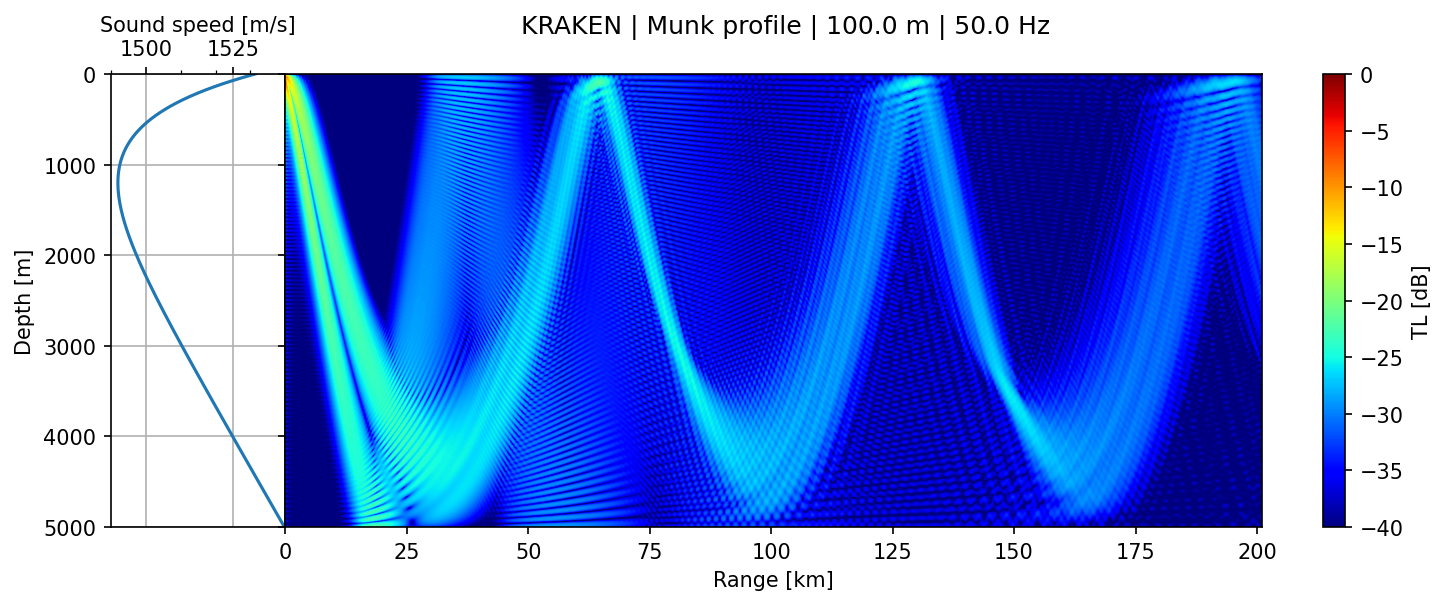

In [17]:
from tritonoa.at.models.kraken import runner

ssp_data = munk_ssp(5000, 5)
z_data = ssp_data["z"]
c_data = ssp_data["c_p"]

environment = {
    # 1. General
    "title": "Munk",
    "model": "KRAKEN",
    # 2. Top medium (halfspace)
    # 3. Layered media
    "layerdata": [{"z": z_data, "c_p": c_data, "rho": 1.0}],
    # 4. Bottom medium
    "bot_opt": "A",
    "bot_c_p": 1600,
    "bot_rho": 1.8,
    "bot_a_p": 0.8,
    # 5. Speed constraints
    "clow": 0,
    "chigh": 1600,
    # 6. Receiver parameters
    "rec_z": np.arange(0, z_data.max() + 1, 5).tolist(),
    "rec_r": np.arange(0, 200 + 1, 10 / 1e3).tolist(),
    # 7. Source parameters
    "src_z": 100.0,
    "freq": 50.0,
}

p = runner.run_kraken(environment)
p = normalize_pressure(p, log=True)

fig, axs = plt.subplots(
    1,
    2,
    sharey=True,
    gridspec_kw={"width_ratios": [1, 7], "wspace": 0},
    figsize=(12, 4),
    dpi=150,
    facecolor="w",
)

ax = plot_SSP(z_data, c_data, xlabel="Sound speed [m/s]", ylabel="Depth [m]", ax=axs[0])
ax = plot_TL_2d(
    p,
    z=np.array(environment["rec_z"]),
    r=np.array(np.concatenate((np.array([0]), environment["rec_r"]))),
    xlabel="Range [km]",
    clabel="TL [dB]",
    vmin=-40,
    ax=axs[1],
)
fig.suptitle(
    f"{environment['model']} | {environment['title']} profile | {environment['src_z']} m | {environment['freq']} Hz"
)
plt.show()

### Using the `KrakenEnvironment` and `KrakenModel` interface

This interface is a lower-level abstraction of the same input/output of the `runner` interface. In this interface, individual objects constituting the environment required by KRAKEN are constructed manually. The same operations occur within the `run_kraken` convenience function.

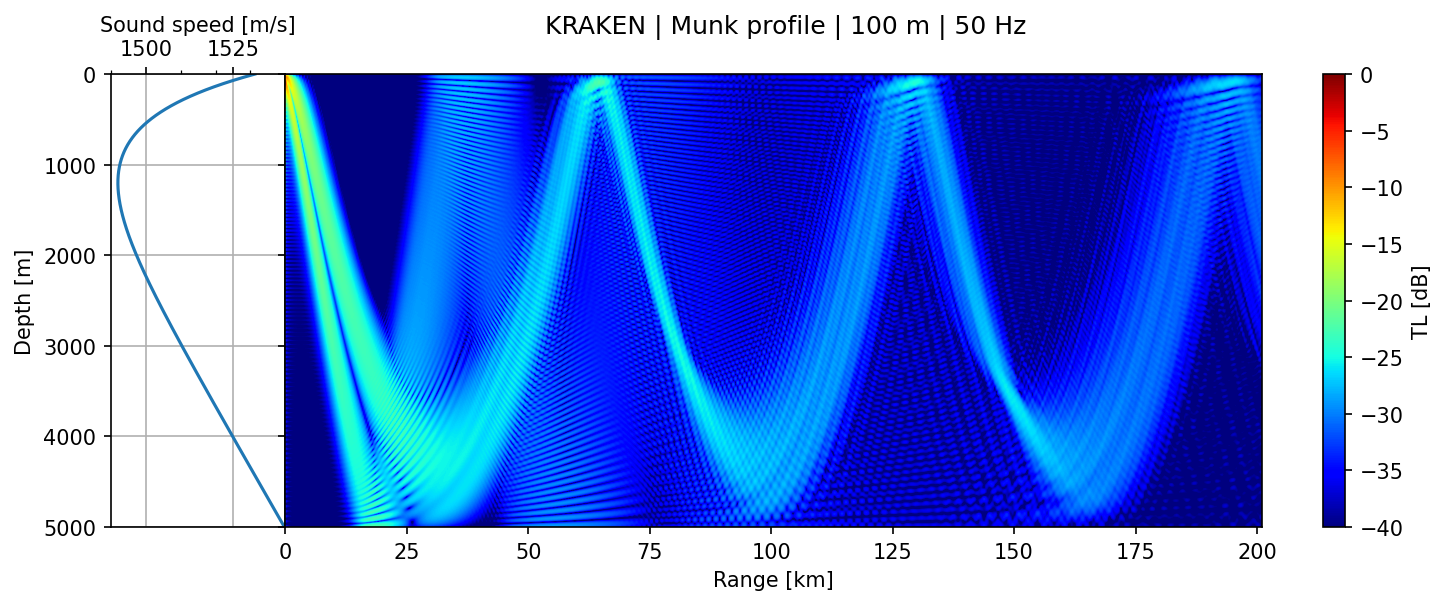

In [18]:
from tritonoa.at.env.array import Receiver, Source
from tritonoa.at.env.halfspace import Bottom, Top
from tritonoa.at.models.kraken.kraken import KrakenEnvironment, KrakenModel
from tritonoa.at.env.ssp import SSPLayer, SoundSpeedProfileAT

title = "Munk"
model = "KRAKEN"

ssp_data = munk_ssp(5000, 5)
z_data = ssp_data["z"]
c_data = ssp_data["c_p"]

top = Top()

ssp = SoundSpeedProfileAT(z=z_data, c_p=c_data)
layer = SSPLayer(ssp)
layers = [layer]

bottom = Bottom(opt="A", z=layer.z_max, c_p=1600, rho=1.8, a_p=0.8)

src_z = 100
source = Source(src_z)
zvec = np.arange(0, layer.z_max + 1, 5)
rvec = np.arange(0, 201, 10 / 1e3)

receiver = Receiver(z=zvec, r=rvec)

freq = 50
clow = 1500
chigh = 1600

kraken_env = KrakenEnvironment(
    title,
    freq,
    layers,
    top,
    bottom,
    tmpdir="tmp",
    source=source,
    receiver=receiver,
    clow=clow,
    chigh=chigh,
)

kraken_model = KrakenModel(kraken_env)
kraken_model.run(model_name=model, fldflag=True)
p = kraken_model.modes.p
p = normalize_pressure(p, log=True)

fig, axs = plt.subplots(
    1,
    2,
    sharey=True,
    gridspec_kw={"width_ratios": [1, 7], "wspace": 0},
    figsize=(12, 4),
    dpi=150,
    facecolor="w",
)

ax = plot_SSP(z_data, c_data, xlabel="Sound speed [m/s]", ylabel="Depth [m]", ax=axs[0])
ax = plot_TL_2d(
    p,
    z=zvec,
    r=np.array(np.concatenate((np.array([0]), rvec))),
    xlabel="Range [km]",
    clabel="TL [dB]",
    vmin=-40,
    ax=axs[1],
)
fig.suptitle(f"{model} | {title} profile | {src_z} m | {freq} Hz")
plt.show()